In [1]:
from pair_trading.basic_tool import lag, maximum, minimum, crossover, crossunder, preprocess
from pair_trading.strategy import Strategy
from pair_trading.analysis import Analysis

import pandas as pd
from datetime import datetime

In [2]:
data = pd.read_csv('data/data.csv')
data.date = data.date.apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))
data.head()

,id,name,date,open,high,low,close,volume,foreign,trust,dealer
0,1101,台泥,2000-12-12,5.78,5.93,5.75,5.82,11092,414,40,100
1,1102,亞泥,2000-12-12,4.89,4.97,4.89,4.94,2112,1016,200,0
2,1216,統一,2000-12-12,6.58,6.70,6.55,6.58,5951,2472,-100,51
3,1301,台塑,2000-12-12,13.38,13.51,13.24,13.24,3679,34,-250,-28
4,1303,南亞,2000-12-12,12.16,12.33,12.13,12.24,10237,2441,1217,-180


## 資料前處理

In [3]:
# data
stock_2330 = data[data.id == 2330]
stock_1101 = data[data.id == 1101]
stock_2330, stock_1101 = preprocess(stock_2330, stock_1101)

# 計算指標
stock_2330['ma20'] = stock_2330.close.rolling(20).mean()
stock_2330['ma5'] = stock_2330.close.rolling(5).mean()
stock_1101['ma20'] = stock_1101.close.rolling(20).mean()
stock_1101['ma5'] = stock_1101.close.rolling(5).mean()

## 撰寫進出場策略(Strategy)

In [4]:
# 撰寫進出場條件
# (條件為list，若依序填入則為條件皆符合才觸發條件("且"))
# 進場訊號
condition_in = [
    # 此為"且"的寫法
    # 台積電今日收盤價高過於前十日最高價
    stock_2330.close > lag(maximum(stock_2330.high, 10)),
    # "且"今日收紅k
    stock_2330.close > stock_2330.open
]

# 出場訊號
condition_out = [
    # 此為"或"的寫法
    (
        # 台積電20日平均死亡交叉5日平均(類似Multicharts語法)
        (crossunder(stock_2330.ma20, stock_2330.ma5)) |
        # "或"今日收黑小於0.03%的黑k
        ((stock_2330.close - stock_2330.open)/stock_2330.open < -0.03)
    )
]

In [5]:
# 建立Strategy物件
example_strategy = Strategy(
    # 訊號出現後何時進出場，0為出現後馬上執行交易，1為下一個價格執行交易，2...以此類推
    next_bar=1,
    # 以甚麼價格進行交易
    trade_on='close',
    # 初始資金(後續分析中沒有使用到)
    initial_capital=1000000,
    # 交易稅
    tax_rate=0.003,
    # 交易成本(率)
    cost=0.001425
)

In [6]:
# 開始回測
example_strategy.run(
    # condition_in成立時欲做多的股票
    stock_2330,
    # condition_in成立時欲放空的股票
    stock_1101,
    # 進場訊號
    condition_in,
    # 出場訊號
    condition_out,
    # 對沖比率，預設為auto，亦即將兩兩欲交易的價格進行比較(trade_on)，
    # 將價格較高者部位設為1，價格較低者部位則由高價除以低價並四捨五入
    # 也可以輸入list如；[2, 1]，將會以2:1的部位進行交易(stock_to_buy:stock_to_sellshort)
    hedge_ratio='auto'
)

In [7]:
# 進出場訊號及部位持有狀況
example_strategy.signal.iloc[19:30]

,condition_in,condition_out,stock_to_buy_position,stock_to_sellshort_position
19,False,False,1000.0,-4000.0
20,False,False,1000.0,-4000.0
21,False,False,1000.0,-4000.0
22,False,False,1000.0,-4000.0
23,False,False,1000.0,-4000.0
24,False,False,1000.0,-4000.0
25,True,False,1000.0,-4000.0
26,False,False,1000.0,-4000.0
27,False,False,1000.0,-4000.0
28,False,True,1000.0,-4000.0


In [8]:
# 詳細部位持有狀況，存於stock_to_xxx_trade_table中
# 以下以做多交易為例
example_strategy.stock_to_buy_trade_table.iloc[19:30]

,date,close_price,holdings,entry_exit_points,cash,total_value,cumulative_profit
19,2001-01-08,22.34,22340.0,1000.0,977660.0,1000000.0,0.0
20,2001-01-09,23.22,23220.0,0.0,977660.0,1000880.0,880.0
21,2001-01-10,23.47,23470.0,0.0,977660.0,1001130.0,1130.0
22,2001-01-11,23.09,23090.0,0.0,977660.0,1000750.0,750.0
23,2001-01-12,23.47,23470.0,0.0,977660.0,1001130.0,1130.0
24,2001-01-15,23.59,23590.0,0.0,977660.0,1001250.0,1250.0
25,2001-01-16,25.21,25210.0,0.0,977660.0,1002870.0,2870.0
26,2001-01-17,25.21,25210.0,0.0,977660.0,1002870.0,2870.0
27,2001-01-18,25.46,25460.0,0.0,977660.0,1003120.0,3120.0
28,2001-01-29,24.21,24210.0,0.0,977660.0,1001870.0,1870.0


## 分析策略結果(Analysis)

In [9]:
# 建立分析物件
example_strategy_analysis = Analysis(
    # 欲分析的策略
    example_strategy
)

# 進行分析
example_strategy_analysis.run()

In [10]:
# 策略績效基本資訊
example_strategy_analysis.summary(
    # 檢視策略績效總結果，另有'buy'(做多交易), 'sellshort'(放空交易)
    select_result='total'
)

,total_profit,average_return,winning_rate,max_drowdown,average_holding_days,total_trade_number
0,-13446.7115,-0.0156,0.451,91340.9822,39.5784,102


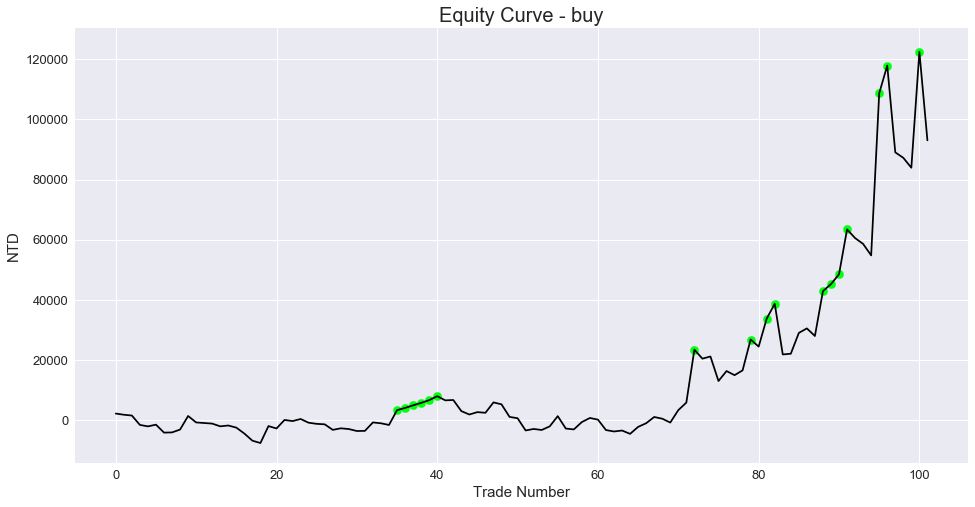

In [11]:
# 策略權益曲線
example_strategy_analysis.plot_equity_curve(
    # 另有'total'(總交易), 'sellshort'(放空交易)
    select_result='buy'
)

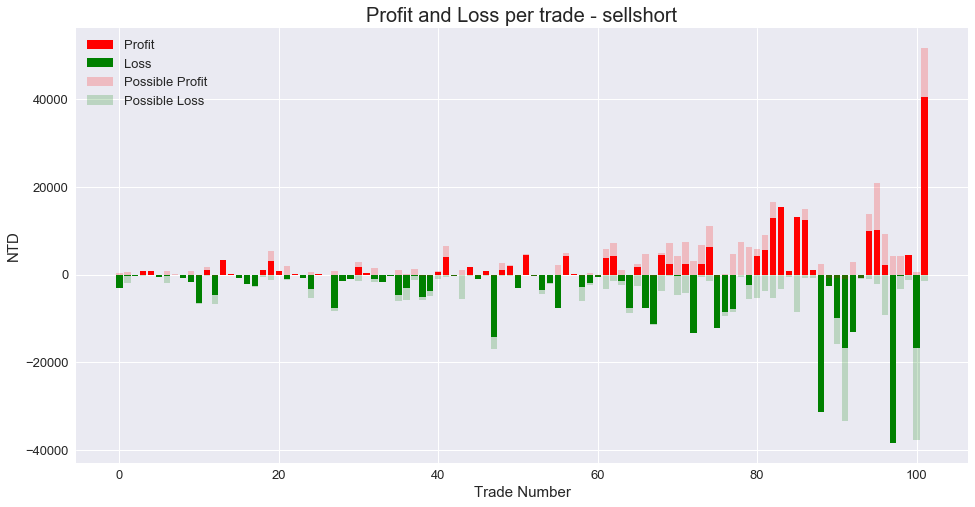

In [12]:
# 策略獲利與虧損(每筆)
example_strategy_analysis.plot_profit_and_loss_per_trade(
    # 另有'total'(總交易), 'buy'(做多交易)
    select_result='sellshort'
)

In [13]:
# 詳細部位持有狀況(來自example_strategy，因此上面出現過)
example_strategy_analysis.stock_to_buy_trade_table.iloc[19:30]

,date,close_price,holdings,entry_exit_points,cash,total_value,cumulative_profit
19,2001-01-08,22.34,22340.0,1000.0,977660.0,1000000.0,0.0
20,2001-01-09,23.22,23220.0,0.0,977660.0,1000880.0,880.0
21,2001-01-10,23.47,23470.0,0.0,977660.0,1001130.0,1130.0
22,2001-01-11,23.09,23090.0,0.0,977660.0,1000750.0,750.0
23,2001-01-12,23.47,23470.0,0.0,977660.0,1001130.0,1130.0
24,2001-01-15,23.59,23590.0,0.0,977660.0,1001250.0,1250.0
25,2001-01-16,25.21,25210.0,0.0,977660.0,1002870.0,2870.0
26,2001-01-17,25.21,25210.0,0.0,977660.0,1002870.0,2870.0
27,2001-01-18,25.46,25460.0,0.0,977660.0,1003120.0,3120.0
28,2001-01-29,24.21,24210.0,0.0,977660.0,1001870.0,1870.0


In [14]:
# stock_to_xxx_trade_table為詳細部位持有狀況
# stock_to_xxx_trade_result則為每筆交易資訊
example_strategy_analysis.stock_to_buy_trade_result.head()

,entry_date,exit_date,holding_date,position_size,entry_price,exit_price,gross_profit,gross_return,trade_cost,net_profit,net_return,maximum_favorable_excursion,maximum_adverse_excursion
0,2001-01-08,2001-01-30,22,1000.0,22.34,24.71,2370.0,0.106088,141.17625,2228.82375,0.099768,2978.82375,-141.17625
1,2001-02-01,2001-02-15,14,1000.0,25.34,25.09,-250.0,-0.009866,147.13275,-397.13275,-0.015672,-147.13275,-2897.13275
2,2001-03-26,2001-03-27,1,1000.0,22.47,22.34,-130.0,-0.005785,130.87425,-260.87425,-0.011610,-130.87425,-260.87425
3,2001-06-12,2001-06-22,10,1000.0,24.21,21.22,-2990.0,-0.123503,128.39775,-3118.39775,-0.128806,-128.39775,-3118.39775
4,2001-07-03,2001-07-04,1,1000.0,23.79,23.44,-350.0,-0.014712,137.62275,-487.62275,-0.020497,-137.62275,-487.62275
